In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
# アイリスデータセットの読み込み
df = sns.load_dataset("iris")

# 先頭5行の確認
display(df.head())

#  speciesの分布確認
df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [4]:
# versicolorの行のみ抽出
df1 = df.query('species == "versicolor"')

# sepal_lengthとsepal_widthの列を抽出
X = df1["sepal_length"]
Y = df1["sepal_width"]

Text(0, 0.5, 'sepal_width')

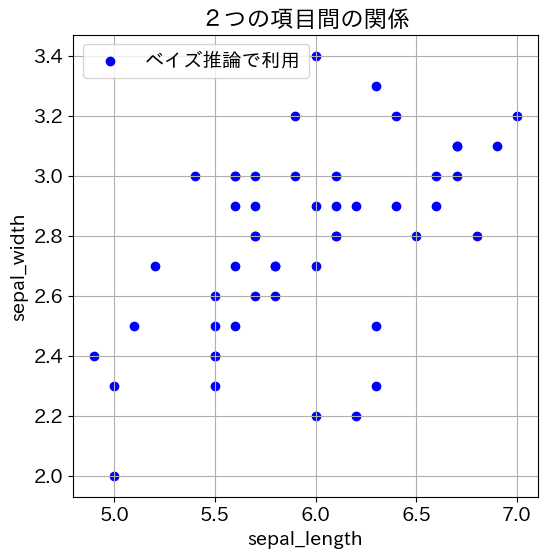

In [5]:
plt.title("２つの項目間の関係")
plt.scatter(X, Y, label="ベイズ推論で利用", c="b", marker="o")
plt.legend()
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")

In [6]:
model1 = pm.Model()

with model1:
    # --------------------------------------------------------------
    # ここでは「単回帰モデル」をベイズ的に書き下ろしている。
    #
    #   観測データ (X_i, Y_i) が与えられているとき、
    #   真の生成過程を
    #
    #       Y_i = α X_i + β + e_i
    #
    #   とみなし、誤差項 e_i を平均 0 の正規分布
    #
    #       e_i ~ Normal(0, ε^2)
    #
    #   に従うと仮定している。
    #   そのとき尤度は
    #
    #       Y_i | α, β, ε ~ Normal(α X_i + β, ε^2)
    #
    #   となる。この α, β, ε に対して事前分布を置き、
    #   観測データ Y から事後分布 p(α, β, ε | X, Y) を推論するのが
    #   本コードの目的である。
    # --------------------------------------------------------------

    # --------------------------------------------------------------
    # 傾き α（alpha）と切片 β（beta）の事前分布
    #
    # ・alpha: 傾き（一次関数の係数）
    # ・beta : 切片
    #
    # どちらも平均 0, 標準偏差 10 の広い正規分布を事前として採用。
    # これは「X と Y のスケールに対して、かなり幅広く可能性を許す
    # 非情報的（weakly-informative）なガウス事前」に相当する。
    #
    # 例えば X, Y がだいたい数個〜十数個のオーダーであれば、
    # α, β が ±20 程度までは十分高い事前確率を持つ設定であり、
    # 事後は主にデータに引っ張られることが期待される。
    # --------------------------------------------------------------
    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
    beta = pm.Normal("beta", mu=0.0, sigma=10.0)

    # --------------------------------------------------------------
    # 線形予測子 μ の定義
    #
    #   μ_i = α X_i + β
    #
    # という線形モデルをベクトル/配列 X に対して一括で計算している。
    # この μ は「条件付き平均 E[Y | X, α, β]」に対応し、
    # 尤度である Normal 分布の位置パラメータとして利用される。
    #
    # ここでは X が NumPy 配列や pandas Series であることを想定しており、
    # ブロードキャストにより各点 i について μ_i が一度に計算される。
    # --------------------------------------------------------------
    mu = alpha * X + beta

    # --------------------------------------------------------------
    # ノイズの標準偏差 ε（epsilon）の事前分布
    #
    #   ε > 0 でなければならないため、半正規分布 HalfNormal を使用。
    #
    #   epsilon ~ HalfNormal(σ = 1.0)
    #
    # という事前は、「誤差のスケールは 0 付近がやや好ましいが、
    # 1 以上の値も排除しない」という弱い事前知識を表す。
    # もし実際の Y のスケールがもっと大きい（例: 標準偏差が 10 程度）
    # 場合は、sigma をそのスケールに合わせて拡大すべきである。
    #
    # HalfNormal を使うことで
    #
    #   ・常に ε >= 0 が保証される
    #   ・0 に近い値ほど事前密度が高い
    #
    # という性質を自然に表現できる。
    # --------------------------------------------------------------
    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    # --------------------------------------------------------------
    # 観測モデル（尤度）の定義
    #
    #   Y_obs_i | α, β, ε ~ Normal(μ_i, ε^2)
    #
    # ここで
    #   μ_i = α X_i + β
    # を上で定義済み。
    #
    # PyMC では「観測を持つ確率変数」を observed= 引数で指定する。
    # このとき Y_obs 自体は「Y の確率変数」でありつつ、
    # その取りうる値として実データ Y が固定される。
    #
    # ベイズ的には、この行が尤度 p(Y | α, β, ε) を定義しており、
    # 事前分布 p(α) p(β) p(ε) と合わせて
    #
    #   事後分布 p(α, β, ε | X, Y)
    #
    # を規定することになる。
    # 以降は pm.sample(...) を呼び出すことで、この事後分布から
    # サンプルを生成し、回帰係数とノイズの不確実性を同時に推論していく。
    # --------------------------------------------------------------
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y)

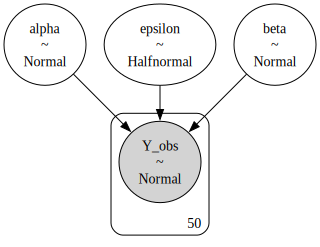

In [7]:
g = pm.model_to_graphviz(model1)
display(g)